In [1]:
import pandas as pd
import geopandas as gpd
import folium
import os
import sqlite3
import matplotlib.pylab as plt
from scipy import stats
import numpy as np
%config Completer.use_jedi = False #for auto complete code

In [2]:
#para el ttest pvalue debe ser mayor a 0.05 para aceptar de que son la misma muestra
def tables_in_sqlite_db(conn):
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [
        v[0] for v in cursor.fetchall()
        if v[0] != "sqlite_sequence"
    ]
    cursor.close()
    return tables

def gauge_stations(df,cuencas_shp,this_map,cuenca_name):
    geometry=cuencas_shp[cuencas_shp.NOMBRE==cuenca_name]['geometry']
    def add_geo(geometry,this_map):
        sim_geo=gpd.GeoSeries(geometry).simplify(tolerance=0.001)
        geo_j= sim_geo.to_json()
        geo_j=folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor':'orange'})
        geo_j.add_to(this_map)
        
    def plotDot(df):
        popup_name=df.NOMBRE_ESTACION+' '+df.CATEGORIA
        folium.CircleMarker(location=[df.LATITUD,df.LONGITUD],popup=popup_name,radius=2).add_to(this_map)
        
    add_geo(geometry,this_map)
    df.apply(plotDot, axis = 1)
    
    return this_map
        

class Estacion:
    def __init__(self,database):
        self.database = database
        sql_query= "SELECT * FROM Maestro"
        self.Maestro = pd.read_sql(sql_query, conn)
        
        
        self.tables_clima={}
        

    def get_Maestro(self):
        return self.Maestro

    def estaciones_por_dz(self,num):
        self.tables_dz={}
        tables = tables_in_sqlite_db(self.database)
        filtro= self.Maestro[self.Maestro.DZ==num]
        name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
        
        for i,estacion in enumerate(filtro.CODIGO):
            estacion='T'+str(estacion)
            if estacion in tables:
                sql_query= "SELECT * FROM "+estacion
                
                self.tables_dz[name[i]]=pd.read_sql(sql_query, conn)
                
        return self.tables_dz
    
    def estaciones_por_cuenca_dz(self,num):
        self.gauge_cuenca={}
        self.cod_gauge_cuenca={}
        
        tables = tables_in_sqlite_db(self.database)
        filtro= self.Maestro[self.Maestro.DZ==num]
        for cuenca in filtro.Cuenca:
            self.gauge_cuenca[cuenca]=[]
            self.cod_gauge_cuenca[cuenca]=[]
            
        cuencas=list(filtro.Cuenca)
        for i,estacion in enumerate(filtro.CODIGO):
            estacion_table='T'+str(estacion)
            if estacion_table in tables:
                cuenca=cuencas[i]
                sql_query= "SELECT * FROM "+estacion_table
                self.gauge_cuenca[cuenca].append(pd.read_sql(sql_query, conn))
                self.cod_gauge_cuenca[cuenca].append(estacion)
            
        return (self.cod_gauge_cuenca,self.gauge_cuenca)
        
class Convencional(Estacion):
    def __init__(self,**kwargs):
        super(Convencional,self).__init__(**kwargs)
    
    def plot_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']]=df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].apply(pd.to_numeric,errors='coerce')
            df.plot(x='Fecha Reg',y=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med'],figsize = (25,10),title=estacion)
        plt.show()
        
    def stats_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            print(estacion)
            print(df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].describe())
    
    
    def max_historic_and_previous(self):
        self.stats_previous_historic=[]
        for estacion in self.tables_dz:
            df=self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            
            cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']
            df[cols]=df[cols].apply(pd.to_numeric,errors='coerce')
            
            #Todos los anos presentes en la base de datos
            idx_years=pd.DatetimeIndex(df['Fecha Reg']).year
            years=np.unique(idx_years)
            if len(years)>=2:
                year0=years[0]
                previous_year=years[-2]
                present_year=years[-1]

                #year evaluation
                df_previous=df[idx_years==previous_year]
                df_historic=df[idx_years!=present_year]

                #month evaluation
                month_previous=pd.DatetimeIndex(df_previous['Fecha Reg']).month
                avenida_previous=(month_previous==1) | (month_previous==2) | (month_previous==3) | (month_previous==4)
                estiaje_previous=(month_previous==6) | (month_previous==7) | (month_previous==8) | (month_previous==9)

                month_historic = pd.DatetimeIndex(df_historic['Fecha Reg']).month
                avenida_historic=(month_historic==1) | (month_historic==2) | (month_historic==3) | (month_historic==4)
                estiaje_historic=(month_historic==6) | (month_historic==7) | (month_historic==8) | (month_historic==9)


                Estacion_niveles= [estacion+' '+col for col in cols]

                stats_df={}
                stats_df['Estaciones']=Estacion_niveles
                #stats_df['max año previo '+str(previous_year)]=list(df_previous[cols].max())
                #stats_df['max historico '+str(year0)+'-'+str(previous_year)]=list(df_historic[cols].max())
                
                stats_df['Año de Inicio']=list(np.repeat(year0,5))
                stats_df['Año de Fin']=list(np.repeat(present_year,5))
                stats_df['max año previo']=list(df_previous[cols].max())
                stats_df['max historico']=list(df_historic[cols].max())

                stats_df['max año previo estiaje']=df_previous[estiaje_previous][cols].max()
                stats_df['max año previo avenida']=df_previous[avenida_previous][cols].max()

                stats_df['max año historico estiaje']=list(df_historic[estiaje_historic][cols].max())
                stats_df['max año historico avenida']=list(df_historic[avenida_historic][cols].max())
                self.stats_previous_historic.append(pd.DataFrame(stats_df))
            else:
                print(estacion+ 'tiene menos de dos años de registro '+str(years))        
        return self.stats_previous_historic
    
    
class Automatica(Estacion):
    pass

      

In [3]:
conn = sqlite3.connect('../data/DZ/niveles.db')
cuencas_shp=gpd.read_file('../data/shp/cuencas/UH.shp')
Estacion_convencional=Convencional(database=conn)

In [4]:
Estacion_convencional.get_Maestro().head(10)

,INVENTARIO_SINCERADO,DZ,NOMBRE_ESTACION,CODIGO,CATEGORIA,CLASIFICACION,TIPO,COMUNICACION,FECHA_DE_INSTALACION,ESTADO_FUNCIONAMIENTO,...,LATITUD,LONGITUD,Lat_Sexagesimal,Lot_Sexagesimal,ALTITUD,DEPARTAMENTO,PROVINCIA,DISTRITO,COD_Clima,Cuenca
0,NO,1,CABO_INGA,47E01126,AUTOMATICA,EHA,HIDROLÓGICA,SATELITAL GOES,05/12/14,FUNCIONANDO,...,-3.978733,-80.399381,"-3°58'43.44""","-80°23'57.77""",160.0,TUMBES,TUMBES,SAN JACINTO,"C (i , p) A'",Cuenca Tumbes
1,NO,1,EL_TIGRE,200202,CONVENCIONAL,HLG,HIDROLÓGICA,VOZ Y DATA,01/08/64,FUNCIONANDO,...,-3.768480,-80.456850,"-3°46'6.53""","-80°27'24.66""",36.0,TUMBES,TUMBES,SAN JACINTO,"D (i , p) A'",Cuenca Tumbes
2,NO,1,EL_TIGRE,4724A3F6,AUTOMATICA,EHMA,HIDROMETEOROLÓGICA,SATELITAL GOES,11/08/01,FUNCIONANDO,...,-3.768700,-80.456889,"-3°46'7.32""","-80°27'24.8""",37.0,TUMBES,TUMBES,SAN JACINTO,"D (i , p) A'",Cuenca Tumbes
3,NO,1,PUENTE_TUMBES,47E024BC,AUTOMATICA,EHA,HIDROLÓGICA,SATELITAL GOES,22/10/14,FUNCIONANDO,...,-3.570878,-80.460872,"-3°34'15.16""","-80°27'39.14""",8.0,TUMBES,TUMBES,TUMBES,"D (i , p) A'",Cuenca Tumbes
4,NO,13,PUENTE_LOROCO_CALLACAME,210502,CONVENCIONAL,HLG,HIDROLÓGICA,VOZ Y DATA,09/07/94,FUNCIONANDO,...,-16.570650,-69.322780,"-16°34'14.34""","-69°19'22.01""",3862.0,PUNO,CHUCUITO,KELLUYO,"C (o , i) C'",Cuenca Callaccame
5,NO,13,PUENTE_ZAPATILLA,270503,CONVENCIONAL,HLM,HIDROLÓGICA,VOZ Y DATA,01/01/76,FUNCIONANDO,...,-16.138603,-69.578730,"-16°8'18.97""","-69°34'43.43""",3846.0,PUNO,EL COLLAO,ILAVE,"C (o , i) C'",Intercuenca 0157
6,SI,13,ENAFER,47256412,AUTOMATICA,EHA,HIDROLÓGICA,SATELITAL GOES,SIN_DATO,FUNCIONANDO,...,-15.836493,-70.016030,"-15°50'11.37""","-70°0'57.71""",3812.0,PUNO,PUNO,PUNO,"B (o , i) C'",Intercuenca 0173
7,NO,13,ENAFER,270000,CONVENCIONAL,HLM,HIDROLÓGICA,NINGUNO,01/03/08,PARALIZADA,...,-15.836490,-70.015898,"-15°50'11.36""","-70°0'57.23""",3823.0,PUNO,PUNO,PUNO,"B (o , i) C'",Intercuenca 0173
8,NO,13,PUENTE_CARRETERA,47251282,AUTOMATICA,EHA,HIDROLÓGICA,SATELITAL GOES,30/12/00,FUNCIONANDO,...,-15.255309,-69.873786,"-15°15'19.11""","-69°52'25.63""",3825.0,PUNO,HUANCANE,TARACO,"C (o , i) C'",Intercuenca Ramis
9,NO,13,PUENTE_RAMIS,210101,CONVENCIONAL,HLG,HIDROLÓGICA,VOZ Y DATA,01/01/56,FUNCIONANDO,...,-15.255309,-69.873786,"-15°15'19.11""","-69°52'25.63""",3825.0,PUNO,HUANCANE,TARACO,"C (o , i) C'",Intercuenca Ramis


# Estaciones de la DZ 4

In [5]:
DZ4=Estacion_convencional.estaciones_por_dz(4)
#Estacion_convencional.plot_dz_niveles()

In [6]:
#Estacion_convencional.stats_dz_niveles()

In [7]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())
Estadisticos.to_excel('../data/horizontes/Estadisticos.xlsx',index=False)
Estadisticos.head(20)

,Estaciones,Año de Inicio,Año de Fin,max año previo,max historico,max año previo estiaje,max año previo avenida,max año historico estiaje,max año historico avenida
Nivel 06h,SAN_PEDRO CONVENCIONAL Nivel 06h,2009,2021,2.1900,4.2000,0.8400,2.1600,1.9700,4.2000
Nivel 10h,SAN_PEDRO CONVENCIONAL Nivel 10h,2009,2021,2.2200,4.0850,0.8675,2.2050,1.8275,4.0850
Nivel 14h,SAN_PEDRO CONVENCIONAL Nivel 14h,2009,2021,NaN,NaN,NaN,NaN,NaN,NaN
Nivel 18h,SAN_PEDRO CONVENCIONAL Nivel 18h,2009,2021,NaN,NaN,NaN,NaN,NaN,NaN
Nivel Med,SAN_PEDRO CONVENCIONAL Nivel Med,2009,2021,2.2200,4.0850,0.8675,2.2050,1.8275,4.0850
Nivel 06h,CAHUA CONVENCIONAL Nivel 06h,1994,2020,2.8600,4.0000,1.7000,2.8600,1.8400,4.0000
Nivel 10h,CAHUA CONVENCIONAL Nivel 10h,1994,2020,2.8500,4.0000,1.6800,2.8500,1.8200,4.0000
Nivel 14h,CAHUA CONVENCIONAL Nivel 14h,1994,2020,2.8400,25.0000,1.6600,2.8400,25.0000,4.0000
Nivel 18h,CAHUA CONVENCIONAL Nivel 18h,1994,2020,2.8200,4.0000,1.6500,2.8200,2.0000,4.0000
Nivel Med,CAHUA CONVENCIONAL Nivel Med,1994,2020,2.8425,6.4375,1.6725,2.8425,6.4375,3.9950


# Estaciones de la DZ 9

In [8]:
DZ9=Estacion_convencional.estaciones_por_dz(9)
#Estacion_convencional.plot_dz_niveles()

In [9]:
#Estacion_convencional.stats_dz_niveles()

In [10]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())

PICOTA CONVENCIONALtiene menos de dos años de registro [1970]


In [11]:
Estadisticos.head(20)

,Estaciones,Año de Inicio,Año de Fin,max año previo,max historico,max año previo estiaje,max año previo avenida,max año historico estiaje,max año historico avenida
Nivel 06h,CAMPANILLA CONVENCIONAL Nivel 06h,1998,2020,13.8800,17.7500,11.4000,13.8800,13.8500,15.8200
Nivel 10h,CAMPANILLA CONVENCIONAL Nivel 10h,1998,2020,13.8500,15.8700,11.4000,13.8500,13.7800,15.8700
Nivel 14h,CAMPANILLA CONVENCIONAL Nivel 14h,1998,2020,13.9500,15.8700,11.4000,13.9500,13.7500,15.8700
Nivel 18h,CAMPANILLA CONVENCIONAL Nivel 18h,1998,2020,13.9200,16.5000,11.4000,13.9200,13.7500,16.5000
Nivel Med,CAMPANILLA CONVENCIONAL Nivel Med,1998,2020,13.8825,15.8225,11.4000,13.8825,13.7825,15.8225
Nivel 06h,SHAMBOYACU CONVENCIONAL Nivel 06h,1996,2020,2.6500,3.9000,2.2400,1.7600,2.4800,3.5000
Nivel 10h,SHAMBOYACU CONVENCIONAL Nivel 10h,1996,2020,3.0000,4.9500,2.4500,3.0000,4.9500,3.5400
Nivel 14h,SHAMBOYACU CONVENCIONAL Nivel 14h,1996,2020,4.0000,4.0600,2.6500,4.0000,3.7500,4.0600
Nivel 18h,SHAMBOYACU CONVENCIONAL Nivel 18h,1996,2020,2.9000,3.4500,2.1000,2.9000,2.8800,3.4500
Nivel Med,SHAMBOYACU CONVENCIONAL Nivel Med,1996,2020,2.2600,3.2625,1.8425,2.2600,2.9500,3.0275


# Estacione ubicadas en cuencas especificas

In [12]:
DZ4_cuenca_estaciones,DZ4_cuencas=Estacion_convencional.estaciones_por_cuenca_dz(4)
DZ9_cuenca_estaciones,DZ9_cuencas=Estacion_convencional.estaciones_por_cuenca_dz(9)

In [13]:
maestro =Estacion_convencional.get_Maestro()
mapa=folium.Map(location=[maestro.LATITUD.mean(),maestro.LONGITUD.mean()],zoom_start=6)

In [14]:
for cuenca in DZ4_cuenca_estaciones:
    filtro=maestro[maestro['CODIGO'].isin(DZ4_cuenca_estaciones[cuenca])]
    gauge_stations(filtro,cuencas_shp,mapa,cuenca)

for cuenca in DZ9_cuenca_estaciones:
    filtro=maestro[maestro['CODIGO'].isin(DZ9_cuenca_estaciones[cuenca])]
    gauge_stations(filtro,cuencas_shp,mapa,cuenca)

In [15]:
mapa

# Estaciones faltantes en el maestro

Estaciones con pocos años de registro estan faltando en el maestro 

In [16]:
Maestro=Estacion_convencional.get_Maestro()

directory ='../data/DZ/DZ_04_LIMA_NIV/'
table_names = [file.split('.')[0].split('_')[1] for file in os.listdir(directory)]
tables = tables_in_sqlite_db(conn)
#for i,code in enumerate(table_names):
#    print(code,Maestro[Maestro.CODIGO==code][['DZ','NOMBRE_ESTACION']])


filtro=Maestro[Maestro.DZ==4]
name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
for i,estacion in enumerate(filtro.CODIGO):
    estacion='T'+str(estacion)
    if estacion in tables:
        #print(estacion,name[i])
        print(f'se encuentra en el maestro: {estacion} y nombre {name[i]}')
        tables.remove(estacion)
        pass
    else:
        #print(f'no se encuentra en el maestro: {tables[i]}')
        pass
        
directory ='../data/DZ/DZ_09_SAN_MARTIN_NIV/'
table_names = [file.split('.')[0].split('_')[1] for file in os.listdir(directory)]
filtro=Maestro[Maestro.DZ==9]
name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
for i,estacion in enumerate(filtro.CODIGO):
    estacion='T'+str(estacion)
    if estacion in tables:
        #print(estacion,name[i])
        print(f'se encuentra en el maestro: {estacion} y nombre {name[i]}')
        tables.remove(estacion)
        pass
    else:
        #print(f'no se encuentra en el maestro: {tables[i]}')
        pass

se encuentra en el maestro: T211404 y nombre SAN_PEDRO CONVENCIONAL
se encuentra en el maestro: T202404 y nombre CAHUA CONVENCIONAL
se encuentra en el maestro: T202607 y nombre PICOY CONVENCIONAL
se encuentra en el maestro: T202601 y nombre LAGUNA_SURASACA CONVENCIONAL
se encuentra en el maestro: T212301 y nombre SAYAN CONVENCIONAL
se encuentra en el maestro: T202701 y nombre SANTO_DOMINGO CONVENCIONAL
se encuentra en el maestro: T202802 y nombre OBRAJILLO CONVENCIONAL
se encuentra en el maestro: T202801 y nombre PARIACANCHA CONVENCIONAL
se encuentra en el maestro: T111151 y nombre PUENTE_MAGDALENA CONVENCIONAL
se encuentra en el maestro: T202903 y nombre AUTISHA CONVENCIONAL
se encuentra en el maestro: T202902 y nombre MILLOC CONVENCIONAL
se encuentra en el maestro: T202904 y nombre RIO_BLANCO CONVENCIONAL
se encuentra en el maestro: T202905 y nombre SAN_MATEO CONVENCIONAL
se encuentra en el maestro: T202906 y nombre CHOSICA CONVENCIONAL
se encuentra en el maestro: T202910 y nombre PU

In [17]:
tables

['T111070',
 'T203305',
 'T203004',
 'T202606',
 'T202929',
 'T230802',
 'T203001',
 'T202403',
 'T202803',
 'T221803',
 'T221818',
 'T221817',
 'T230716',
 'T221814',
 'Maestro']

In [18]:
df=DZ4['CAHUA CONVENCIONAL']

In [19]:
Q1 = df['Nivel 06h'].quantile(0.25)
Q3 = df['Nivel 06h'].quantile(0.75)
IQR = Q3 - Q1

outlier_upper=Q3 + 1.5 * IQR

In [20]:
cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']

In [21]:
"""
outliers=[]
for cuenca in DZ4_cuencas:
    n=len(DZ4_cuencas[cuenca])
    if n<=1:
        print(f"cuenca sola {cuenca}")
    else:
        
        for df in DZ4_cuencas[cuenca]:
            for col in cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1

                outlier_upper=Q3 + 1.5 * IQR
                outliers.append(df[df[col]>outlier_upper].index.tolist())
"""

'\noutliers=[]\nfor cuenca in DZ4_cuencas:\n    n=len(DZ4_cuencas[cuenca])\n    if n<=1:\n        print(f"cuenca sola {cuenca}")\n    else:\n        \n        for df in DZ4_cuencas[cuenca]:\n            for col in cols:\n                Q1 = df[col].quantile(0.25)\n                Q3 = df[col].quantile(0.75)\n                IQR = Q3 - Q1\n\n                outlier_upper=Q3 + 1.5 * IQR\n                outliers.append(df[df[col]>outlier_upper].index.tolist())\n'

<AxesSubplot:>

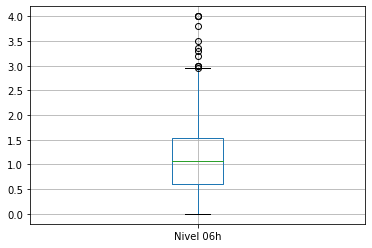

In [22]:
df[['Nivel 06h']].boxplot()

In [23]:
df[df['Nivel 06h']>outlier_upper].index.tolist()

[1189, 6384, 7785, 8159, 8164, 8165, 8166, 8167, 8168, 8169, 8179, 8183]

In [24]:
df[df['Nivel 14h']>outlier_upper]

,Codigo,Estacion,Fecha Reg,ano,mes,dia,Nivel 06h,Nivel 10h,Nivel 14h,Nivel 18h,Nivel Med,Caudal
1189,202404,CAHUA,1998-02-08 00:00:00,1998,FEB,8,4.00,4.00,3.50,3.40,3.7250,None
4292,202404,CAHUA,2006-08-08 00:00:00,2006,AGO,8,0.24,0.26,25.00,0.25,6.4375,None
7785,202404,CAHUA,2016-03-01 00:00:00,2016,MAR,1,3.20,3.18,3.16,3.15,3.1700,None
8164,202404,CAHUA,2017-03-15 00:00:00,2017,MAR,15,3.35,3.32,3.30,3.35,3.3300,None
8165,202404,CAHUA,2017-03-16 00:00:00,2017,MAR,16,3.50,3.48,3.46,3.45,3.4725,None
8166,202404,CAHUA,2017-03-17 00:00:00,2017,MAR,17,4.00,3.90,3.48,3.82,3.8000,None
8167,202404,CAHUA,2017-03-18 00:00:00,2017,MAR,18,3.80,3.80,3.78,3.76,3.7850,None
8168,202404,CAHUA,2017-03-19 00:00:00,2017,MAR,19,4.00,3.98,4.00,4.00,3.9950,None
8169,202404,CAHUA,2017-03-20 00:00:00,2017,MAR,20,3.30,3.20,3.00,2.80,3.0750,None
